In [1]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
#import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
#from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
#from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion, DETR
#################################################################

#Albumenatations
#import albumentations as A
import matplotlib.pyplot as plt
#from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

#added
import json
import itertools
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from numpy.random import rand, randint, ranf, randn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torchvision.transforms.functional as tf
from util.misc import (NestedTensor, nested_tensor_from_tensor_list,
                       accuracy, get_world_size, interpolate,
                       is_dist_avail_and_initialized)
%matplotlib inline

/Users/takeshikibayashi/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Utils

* AverageMeter - class for averaging loss,metric,etc over epochs

In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Configuration

Basic configuration for this model

In [3]:
n_folds = 5
seed = 42
num_classes = 2
num_queries = 20
null_class_coef = 0.5
BATCH_SIZE = 1#8
LR = 2e-5
EPOCHS = 300

# Preparing the Data

* For preparation of data I use code from Alex's awesome kernel [here](https://www.kaggle.com/shonenkov/training-efficientdet)
* The data can be split into any number of folds as you want , split is stratified based on number of boxes and source

In [4]:
PATH = '../laneDetection/data/train_set/'
annotations_list = ['label_data_0313.json', 'label_data_0531.json', 'label_data_0601.json']
gt_list = [[json.loads(line) for line in open(PATH+anno).readlines()] for anno in annotations_list]
gt_list = list(itertools.chain.from_iterable(gt_list))

#PATH = '../laneDetection/data/test_set/'
#annotations_list = ['test_label.json']
#gt_list_test = [[json.loads(line) for line in open(PATH+anno).readlines()] for anno in annotations_list]
#gt_list_test = list(itertools.chain.from_iterable(gt_list_test))
#gt_list = list(itertools.chain.from_iterable([gt_list, gt_list_test]))

In [5]:
train_list, val_list = train_test_split(gt_list, test_size=0.05, shuffle=True)

In [6]:
RESIZE_SCALE = 2
MODEL_SCALE = 16
IMG_WIDTH = 1280
IMG_HEIGHT = 720

In [7]:
def preprocess_image(img, training=False, fliplr=False, shear=0, scale=1, crop=(IMG_WIDTH,IMG_HEIGHT), off=(0,0)):
    
    if training:
        if fliplr:
            img = ImageOps.mirror(img)
        transformed = tf.affine(img, angle=0, translate=(0,0), scale=scale, shear=shear)
        off_x, off_y = off
        img_width, img_height = crop
        cropped = tf.crop(transformed, off_y, off_x, img_height, img_width)
    else:
        cropped = img
    resized = transforms.Resize((IMG_HEIGHT//RESIZE_SCALE,IMG_WIDTH//RESIZE_SCALE))(cropped)
    #resized = np.asarray(resized).astype('float32')
    resized = transforms.ToTensor()(resized)
    
    return resized#.copy() (3, 180, 320) 0~1

def get_lane_points(gt, training=False, fliplr=False, shear=0, scale=1, crop=(IMG_WIDTH,IMG_HEIGHT), off=(0,0)):
    # ground truthの読み込み
    gt_lanes = gt['lanes']
    
    df = pd.DataFrame(gt_lanes, dtype=np.float).T
    df["x"] = gt['h_samples']
    df = df.set_index("x")
    df[df==-2] = np.NaN
    
    model_height = IMG_HEIGHT//RESIZE_SCALE//MODEL_SCALE
    model_width = IMG_WIDTH//RESIZE_SCALE//MODEL_SCALE
    
    # data augmentation
    if training:
        if fliplr:
            df = (IMG_WIDTH - 1) - df
        #transformed = tf.affine(img, angle=0, translate=(0,0), scale=scale, shear=shear)用の変換
        df.index = df.index*scale + IMG_HEIGHT*(1-scale)/2
        df = df*scale + IMG_WIDTH*(1-scale)/2
        off_y = np.array(df.index-IMG_HEIGHT/2).reshape((-1,1))
        df -= off_y*np.tan(shear/180*np.pi)
        #cropped = tf.crop(transformed, off_y, off_x, img_height, img_width)用の変換
        off_x, off_y = off
        img_width, img_height = crop
        df.index -= off_y
        df.index *= model_height/img_height
        df -= off_x
        df *= model_width/img_width
    else:
        img_width, img_height = IMG_WIDTH, IMG_HEIGHT
        df.index *= model_height/img_height
        df *= model_width/img_width
    
    # resize後の画像上の基準高さの行を追加
    df_nan = pd.DataFrame(index=np.arange(0.5,model_height),columns=[0,1,2,3,4,5,6,7,8,9])
    df = pd.concat([df, df_nan])
    # 重複行を削除
    df = df.groupby(level=0)  
    df = df.last()
    # データを内挿,区画線点が1点しかない場合、splineの外挿ができない。その場合は外挿はしない
    for i in range(5):
        try:
            df[i] = df[i].interpolate(method="slinear", limit_area="inside")
            df[i] = df[i].interpolate(limit_direction="forward",method="spline", order=1)
        except:
            pass
        
    # 画像から外れた場所を削除
    df[df<0] = np.NaN
    df[df>model_width] = np.NaN
    
    lane_points = df
    lane_points_scaled = lane_points[np.mod(lane_points.index-0.5,1)==0] # 等間隔のy座標に置けるlane位置のみを抽出
    
    return lane_points_scaled

def line_points_to_label(lane_points):
    arg = np.arange(22)
    labels, xListCoords, yBoundaries = [], [], []
    for i in range(10):
        if not all(np.isnan(lane_points[i].values)):
            isNotLine = np.isnan(lane_points[i].values)
            isLine = np.logical_not(isNotLine)
            labels.append(1 if all(isNotLine) else 0)
            xListCoords.append(lane_points[i].values)
            yBoundaries.append([0,1] if all(isNotLine) else [np.min(arg[isLine]), np.max(arg[isLine])+1])
    return np.array(labels), np.array(xListCoords)/(IMG_WIDTH/RESIZE_SCALE/MODEL_SCALE), np.array(yBoundaries)/22

In [8]:
def get_img_path(gt):
    return PATH+gt['raw_file']

In [9]:
gt = train_list[0]
img_name = gt['raw_file']
img_name_path = get_img_path(gt)
img = Image.open(img_name_path)

#img, offset, scale = preprocess_image(img,True)
fliplr = rand()>.5
shear = (2*rand()-1)*60
scale = .8
crop_width = int((rand()*(1-scale+.2)+scale-.2)*IMG_WIDTH)
crop_height = int((rand()*(1-scale+.2)+scale-.2)*IMG_HEIGHT)
crop = (crop_width, crop_height)
off_x = rand()*(IMG_WIDTH-crop_width)
off_y = rand()*(IMG_HEIGHT-crop_height)
off = (off_x, off_y)
img = preprocess_image(img, True, fliplr, shear, scale, crop, off)
lane_coords = get_lane_points(gt, True, fliplr, shear, scale, crop, off)
labels, xListCoords, yBoundaries = line_points_to_label(lane_coords)
yCoords = lane_coords.index

In [10]:
def drawLine(img, labels, xListCoords, yBoundaries, yCoords):
    
    arg = np.arange(22)
    for label, xList, yBound in zip(labels, xListCoords, yBoundaries):
        if label!=1:
            laneExistUp = yBound[0]*22 <= arg+.5#yBound[0]*MODEL_SCALE < arg
            laneExistDown = arg+.5<= yBound[1]*22#*MODEL_SCALE
            laneExist = np.logical_and(laneExistUp,laneExistDown)
            plt.plot(xList[laneExist]*640, yCoords[laneExist]/22*360,marker='.')
    
    img = np.array(img)
    img = np.rollaxis(img,0,3)
    plt.imshow(img)
    
    plt.xlim([0,IMG_WIDTH//RESIZE_SCALE])

def line2bbox(xListCoords, yBoundaries):
    """output: x0,y0,x1,y1"""
    bbox = np.zeros((xListCoords.shape[0],4))
    x0 = np.nanmin(xListCoords, axis=1)
    x1 = np.nanmax(xListCoords, axis=1)
    y0 = np.nanmin(yBoundaries, axis=1)
    y1 = np.nanmax(yBoundaries, axis=1)
    
    bbox[:,0] = (x0+x1)/2 #cx
    bbox[:,1] = (y0+y1)/2 #cy
    bbox[:,2] = x1-x0 #w
    bbox[:,3] = y1-y0 #h
    
    return bbox

def drawBbox(img, labels, bboxes):
    img = np.array(img)
    img = np.rollaxis(img,0,3)
    height, width, _ = img.shape
    
    bboxes_ = np.zeros_like(bboxes)
    bboxes_[:,0] = (bboxes[:,0]-.5*bboxes[:,2])*width
    bboxes_[:,2] = (bboxes[:,0]+.5*bboxes[:,2])*width
    bboxes_[:,1] = (bboxes[:,1]-.5*bboxes[:,3])*height
    bboxes_[:,3] = (bboxes[:,1]+.5*bboxes[:,3])*height
    
    plt.imshow(img)
    
    for label, (x0,y0,x1,y1) in zip(labels, bboxes_):
        if label!=1:
            plt.plot([x0,x1,x1,x0,x0],[y0,y0,y1,y1,y0])
    
    plt.xlim([0,IMG_WIDTH//RESIZE_SCALE])
    plt.ylim([IMG_HEIGHT//RESIZE_SCALE,0])

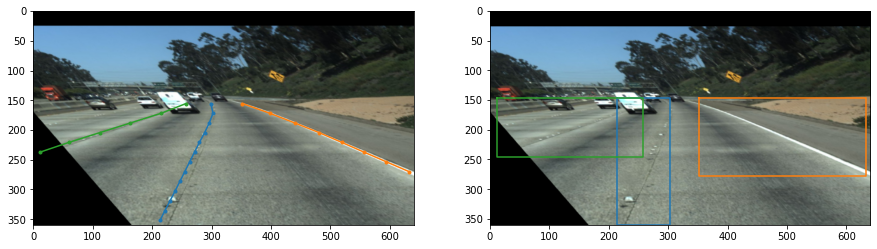

In [11]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
drawLine(img, labels, xListCoords, yBoundaries, yCoords)
plt.subplot(1,2,2)
bboxes = line2bbox(xListCoords, yBoundaries)
drawBbox(img, labels, bboxes)

# Creating Dataset

* I hope you have the video by now , DETR accepts data in coco format which is (x,y,w,h)(for those who do not know there are two formats coco and pascal(smin,ymin,xmax,ymax) which are widely used) . So now we need to prepare data in that format

In [12]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, data_list, training=False):
        self.data_list = data_list
        self.root_dir = PATH
        self.training = training
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Get data for pytorch
        # preprocess is done in self.getitem, and return except for gt
        # because batch process cannot treat not-fixed length
        img, targets = self.getitem(idx)
        
        return img, targets
    
    def getitem(self, idx):
        gt = self.data_list[idx]
        img_name = gt['raw_file']
        img_path = self.root_dir + img_name
        img = Image.open(img_path)
        
        if self.training:
            fliplr = rand()>.5
            shear = (2*rand()-1)*60
            scale = .8
            crop_width = int((rand()*(1-scale+.2)+scale-.2)*IMG_WIDTH)
            crop_height = int((rand()*(1-scale+.2)+scale-.2)*IMG_HEIGHT)
            crop = (crop_width, crop_height)
            off_x = rand()*(IMG_WIDTH-crop_width)
            off_y = rand()*(IMG_HEIGHT-crop_height)
            off = (off_x, off_y)
            img = preprocess_image(img, True, fliplr, shear, scale, crop, off)
        else:
            img = preprocess_image(img)
        
        if self.training:
            lane_coords = get_lane_points(gt, True, fliplr, shear, scale, crop, off)
        else:
            lane_coords = get_lane_points(gt)
        isLines, xListCoords, yBoundaries = line_points_to_label(lane_coords)
        bboxes = line2bbox(xListCoords, yBoundaries)
        # img = np.rollaxis(img, 2, 0) # PILでimageを読み込むように変更したため不要
        
        target = {
            "labels" : torch.as_tensor(isLines),
            "xCoords" : torch.as_tensor(xListCoords),
            "yBounds" : torch.as_tensor(yBoundaries),
            "boxes" : torch.as_tensor(bboxes)
        }
        
        return img, target

In [13]:
train_dataset = CarDataset(train_list, training=True)
val_dataset = CarDataset(val_list, training=True)
val_dataset_noaug = CarDataset(val_list, training=False)

In [14]:
BATCH_SIZE = 16

def collate_fn(batch):
    return tuple(zip(*batch))

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)
val_loader_noaug = DataLoader(dataset=val_dataset_noaug, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

# Model

* Initial DETR model is trained on coco dataset , which has 91 classes + 1 background class , hence we need to modify it to take our own number of classes
* Also DETR model takes in 100 queries ie ,it outputs total of 100 bboxes for every image , we can very well change that too

In [15]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=2)
        self.model.yBound_embed = nn.Linear(in_features=self.in_features,out_features=2)
        self.model.xCoord_embed = nn.Linear(in_features=self.in_features,out_features=22)
        self.model.num_classes = num_classes
        self.model.num_queries = num_queries
        
        
        hidden_dim = self.model.transformer.d_model
        self.model.query_embed = nn.Embedding(num_queries, hidden_dim)
        
    def forward(self,images):
        ## from facebook/DETR
        if isinstance(images, (list, torch.Tensor)):
            images = nested_tensor_from_tensor_list(images)
        features, pos = self.model.backbone(images)

        src, mask = features[-1].decompose()
        assert mask is not None
        hs = self.model.transformer(self.model.input_proj(src), mask, self.model.query_embed.weight, pos[-1])[0]

        outputs_class = self.model.class_embed(hs)
        outputs_yBound = self.model.yBound_embed(hs)
        outputs_xCoord = self.model.xCoord_embed(hs)
        out = {'pred_logits': outputs_class[-1],
               'pred_yBounds': outputs_yBound[-1],
               'pred_xCoords': outputs_xCoord[-1]}
        return out

# Matcher and Bipartite Matching Loss

Now we make use of the unique loss that the model uses and for that we need to define the matcher. DETR calcuates three individual losses :
* Classification Loss for labels(its weight can be set by loss_ce)
* Bbox Loss (its weight can be set by loss_bbox)
* Loss for Background class

In [16]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher()

weight_dict = {'loss_ce': 1, 'loss_yBounds': 1 , 'loss_xCoords': 1}

losses = ['labels', 'yBounds', 'xCoords']

# Eval Function

In [17]:
class SetLaneCriterion(SetCriterion):
    
    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}

        if log:
            # TODO this should probably be a separate loss, not hacked in this one here
            losses['class_error'] = 100 - accuracy(src_logits[idx], target_classes_o)[0]
        return losses
    
    def loss_yBounds(self, outputs, targets, indices, num_boxes):
        assert 'pred_yBounds' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_yBounds = outputs['pred_yBounds'][idx]
        target_yBounds = torch.cat([t['yBounds'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_yBounds = F.l1_loss(src_yBounds, target_yBounds, reduction='none')

        losses = {}
        losses['loss_yBounds'] = loss_yBounds.sum() / num_boxes
        return losses
    
    def loss_xCoords(self, outputs, targets, indices, num_boxes):
        assert 'pred_xCoords' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_xCoords = outputs['pred_xCoords'][idx]
        target_yBounds = torch.cat([t['yBounds'][i] for t, (_, i) in zip(targets, indices)], dim=0)
        target_xCoords = torch.cat([t['xCoords'][i] for t, (_, i) in zip(targets, indices)], dim=0)
        
        target_yBounds_np = target_yBounds.detach().numpy()
        num_line = target_yBounds_np.shape[0]
        arg = np.arange(22)
        args = np.tile(arg, num_line).reshape([-1,22])
        laneExistUp = np.tile(target_yBounds_np[:,0]*22, 22).reshape([22,num_line]).T
        laneExistDown = np.tile(target_yBounds_np[:,1]*22, 22).reshape([22,num_line]).T
        laneExistUp = laneExistUp <= args+.5
        laneExistDown = args+.5<= laneExistDown
        laneExist = np.logical_and(laneExistUp,laneExistDown)
        laneMask = np.zeros_like(target_xCoords)
        laneMask[laneExist] = 1
        laneMask = torch.as_tensor(laneMask)

        loss_xCoords = F.l1_loss(src_xCoords[laneMask==1], target_xCoords[laneMask==1], reduction='none')
        
        losses = {}
        losses['loss_xCoords'] = loss_xCoords.sum() / num_boxes
        return losses

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'yBounds': self.loss_yBounds,
            'xCoords': self.loss_xCoords
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)
    
    def forward(self, outputs, targets):
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}
        xCoords = outputs["pred_xCoords"].detach().numpy()
        yBounds = outputs["pred_yBounds"].detach().numpy()
        
        outputs_without_aux["pred_boxes"] = torch.as_tensor([line2bbox(xs, ys) for xs, ys in zip(xCoords,yBounds)])
        
        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        if is_dist_avail_and_initialized():
            torch.distributed.all_reduce(num_boxes)
        num_boxes = torch.clamp(num_boxes / get_world_size(), min=1).item()

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        return losses

# Engine

In [18]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model = model.to(device)
criterion = SetLaneCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

Using cache found in /Users/takeshikibayashi/.cache/torch/hub/facebookresearch_detr_master


In [20]:
def setOptimizer(lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=1/np.sqrt(10),
                              patience=3,
                              verbose=True
                             )
    return optimizer, scheduler

optimizer, scheduler = setOptimizer(2e-5)

In [21]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    
    total_loss = AverageMeter()
    labels_loss = AverageMeter()
    yBounds_loss = AverageMeter()
    xCoords_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        total_loss.update(losses.item(),BATCH_SIZE)
        labels_loss.update(loss_dict['loss_ce'].item())
        yBounds_loss.update(loss_dict['loss_yBounds'].item())
        xCoords_loss.update(loss_dict['loss_xCoords'].item())
        tk0.set_postfix(total_loss=total_loss.avg,
                        labels=labels_loss.avg*weight_dict['loss_ce'],
                        yBounds=yBounds_loss.avg*weight_dict['loss_yBounds'],
                        xCoords=xCoords_loss.avg*weight_dict['loss_xCoords'])
        
    return total_loss

In [22]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = data_loader
        #tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            #tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss

In [23]:
for param in model.model.backbone.parameters():
    param.required_grad = False
best_map = np.inf

for epoch in range(EPOCHS):
    train_loss = train_fn(train_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
    eval_loss = eval_fn(val_loader, model,criterion, device)
    
    #valid_map_score = calculate_final_score(predictions,0.5,form='coco')

    print('|EPOCH {}| TRAIN_LOSS {}| EVAL_LOSS {}|'.format(epoch+1,train_loss.avg,eval_loss.avg))

    if eval_loss.avg < best_map:
        best_map = eval_loss.avg
        print('Best model found in Epoch {}........Saving Model'.format(epoch+1))
        torch.save(model.state_dict(), f'model/1125_epoch{epoch}_evalLoss{eval_loss.avg}.pth')

KeyboardInterrupt: 

# inference

In [24]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.eval()
state_dict = torch.load("./models/1125_epoch8_evalLoss0.4918245161885654.pth")
model.load_state_dict(state_dict)

Using cache found in /Users/takeshikibayashi/.cache/torch/hub/facebookresearch_detr_master


<All keys matched successfully>

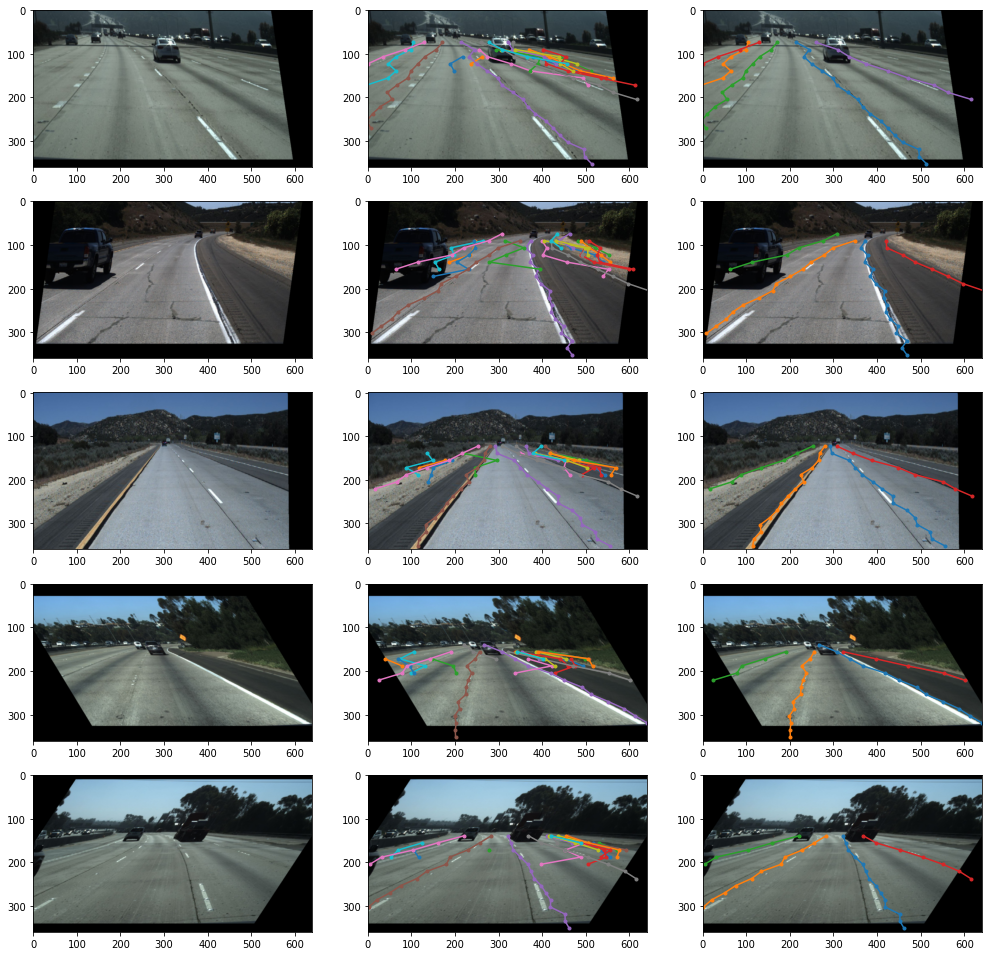

In [61]:
def drawInference(img, output):
    logit_thresh = 0.5
    
    img = np.array(img)
    output["pred_logits"] = output["pred_logits"].sigmoid()
    output = {k: v[0].detach().numpy() for k, v in output.items()}
    
    isLine = np.logical_and(output["pred_logits"][:,0]>output["pred_logits"][:,1],
                            output["pred_logits"][:,0]>logit_thresh)
    isLine = [0 if i==True else 1 for i in isLine]
    
    drawLine(img,
             labels=isLine,
             xListCoords=output["pred_xCoords"],
             yBoundaries=output["pred_yBounds"],
             yCoords=yCoords)

def drawAllInference(img, output):
    output["pred_logits"][:,:,0] = 100
    output["pred_logits"][:,:,1] = -100
    drawInference(img, output)

plt.figure(figsize=(17,17))
for i, r in enumerate(randint(0,len(val_dataset),5)):
    img, target = val_dataset[r]
    
    plt.subplot(5,3,3*i+1)
    plt.imshow(np.rollaxis(np.array(img),0,3))
    
    plt.subplot(5,3,3*i+3)
    output = model(img[None])
    #output = model(torch.tensor(img[None]).to(device))
    drawInference(img, output)
    
    plt.subplot(5,3,3*i+2)
    drawAllInference(img, output)

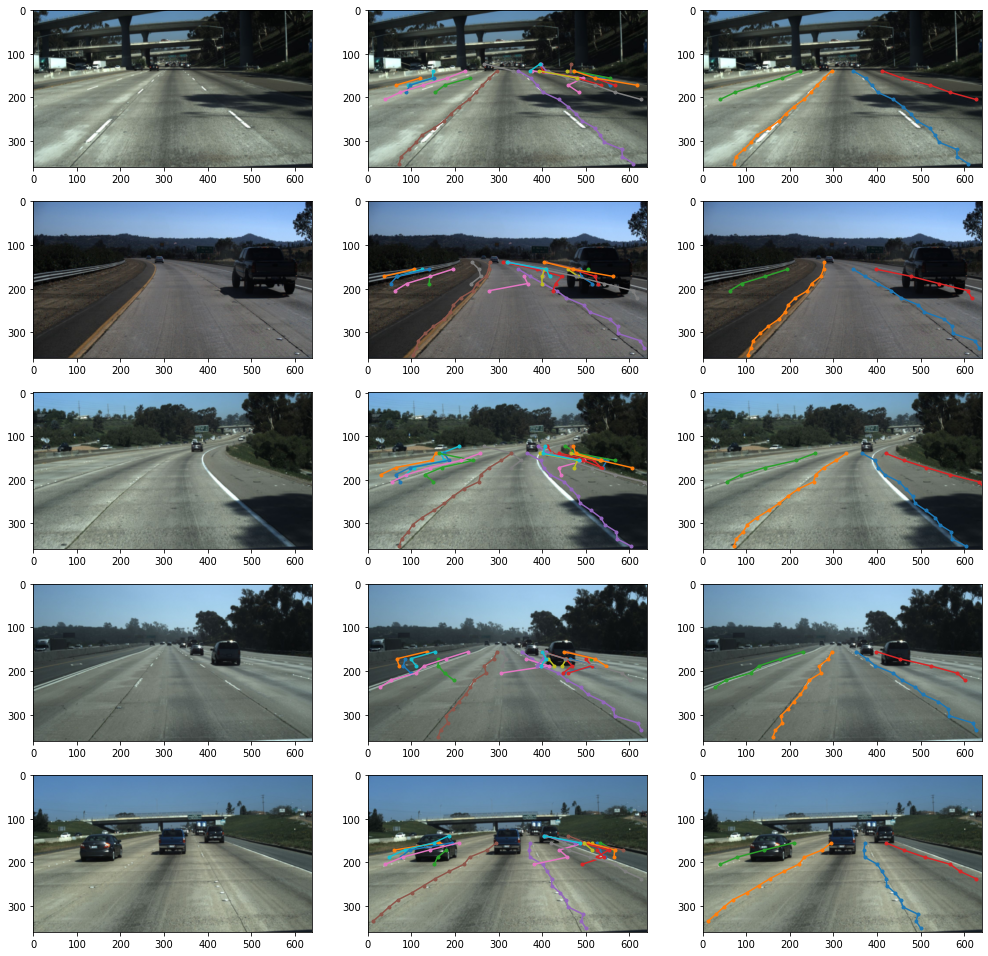

In [64]:
plt.figure(figsize=(17,17))
for i, r in enumerate(randint(0,len(val_dataset_noaug),5)):
    img, target = val_dataset_noaug[r]
    
    plt.subplot(5,3,3*i+1)
    plt.imshow(np.rollaxis(np.array(img),0,3))
    
    plt.subplot(5,3,3*i+3)
    output = model(img[None])
    #output = model(torch.tensor(img[None]).to(device))
    drawInference(img, output)
    
    plt.subplot(5,3,3*i+2)
    drawAllInference(img, output)